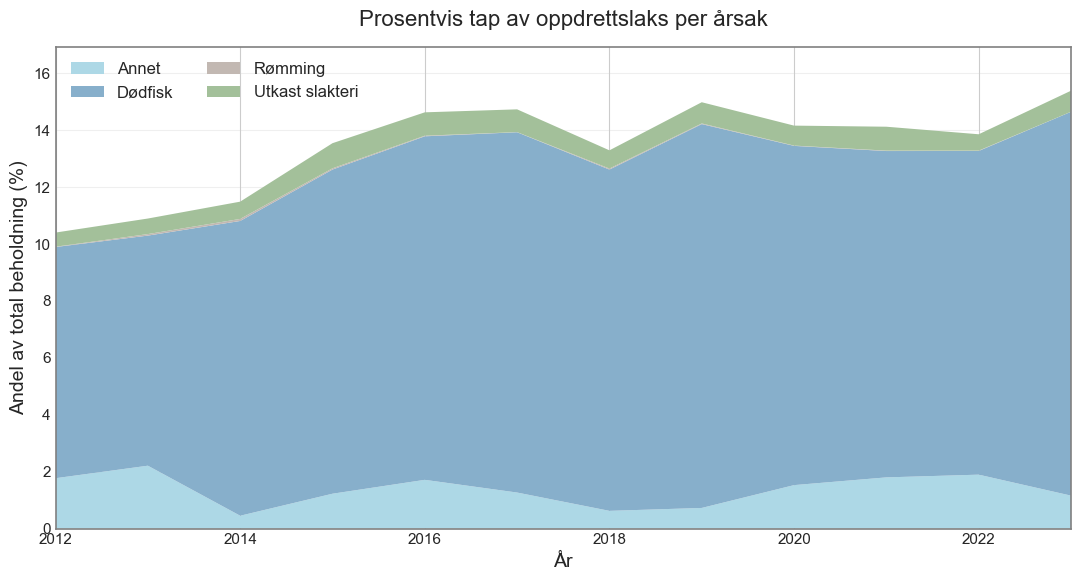

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

# --- Stiloppsett ---
plt.style.use("seaborn-v0_8-whitegrid")  # Ny versjon av seaborn-stilen

mpl.rcParams.update({
    "font.size": 13,
    "axes.titlesize": 16,
    "axes.labelsize": 14,
    "legend.fontsize": 12,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "axes.edgecolor": "gray",
    "axes.linewidth": 1.2,
    "legend.frameon": False,
    "lines.linewidth": 2.2,
    "font.family": "sans-serif",
    "font.sans-serif": ["Arial", "Helvetica", "DejaVu Sans"]
})

# --- 1. Les tapstall ---
tap = pd.read_csv("data/processed/tap_oppdrettslaks.csv")
tap["Antall_fisk"] = tap["Antall (1000)"] * 1000

# --- 2. Les biomasse og regn total beholdning per år ---
biostat = pd.read_csv("data/processed/biostat_tot.csv", sep=";")
biostat["Dato"] = pd.to_datetime(biostat["Dato"])
biostat["År"] = biostat["Dato"].dt.year

# Beregn gjennomsnitt per produksjonsområde, så summer nasjonalt
po_avg = biostat.groupby(["År", "PO"])["BEHFISK_STK"].mean().reset_index(name="Gjennomsnitt_PO")
total_fisk = po_avg.groupby("År")["Gjennomsnitt_PO"].sum().reset_index(name="Total_fisk")

# --- 3. Slå sammen og regn prosent tap per årsak ---
tap_total = pd.merge(tap, total_fisk, on="År", how="inner")
tap_total["Prosent"] = (tap_total["Antall_fisk"] / tap_total["Total_fisk"]) * 100

# --- 4. Pivot til format for area chart ---
df_plot = tap_total.pivot(index="År", columns="Årsak", values="Prosent").fillna(0).sort_index()

# --- 5. Definer farger (rolig og konsistent med tidligere figurer) ---
fargekart = {
    "Dødfisk": "#87AFCB",          # dus blågrå
    "Utkast slakteri": "#A3C09A",  # dempet grønn
    "Rømming": "#C2B8B2",          # gråbrun
    "Annet": "lightblue"             # lys blå
}

# --- 6. Plott area chart ---
fig, ax = plt.subplots(figsize=(11, 6))
ax.stackplot(df_plot.index,
             [df_plot[c] for c in df_plot.columns],
             labels=df_plot.columns,
             colors=[fargekart[c] for c in df_plot.columns])

ax.set_title("Prosentvis tap av oppdrettslaks per årsak", pad=15)
ax.set_xlabel("År")
ax.set_ylabel("Andel av total beholdning (%)")
ax.legend(loc="upper left", ncol=2)
ax.grid(True, which='major', axis='y', alpha=0.3)
ax.set_xlim(df_plot.index.min(), df_plot.index.max())
ax.set_ylim(0, max(df_plot.sum(axis=1)) * 1.1)

plt.tight_layout()

# --- 7. Lagre til fil (valgfritt) ---
# plt.savefig("figurer/prosentvis_tap_area_chart.png", dpi=300)

plt.show()


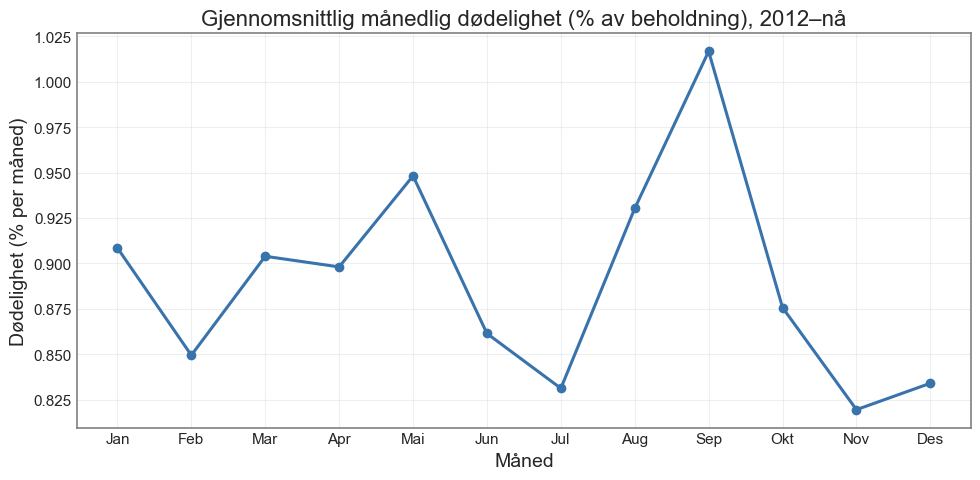

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Les data
df = pd.read_csv("data/processed/biostat_tot.csv", sep=";")
df["Dato"] = pd.to_datetime(df["Dato"])
df["År"] = df["Dato"].dt.year
df["Måned"] = df["Dato"].dt.month

# Filtrer til relevante år
df = df[df["År"] >= 2012]

# Fjern rader uten data
df = df[df["DØDFISK_STK"].notna() & df["BEHFISK_STK"].notna()]

# Beregn prosent dødelighet for hver rad
df["Prosent_død"] = (df["DØDFISK_STK"] / df["BEHFISK_STK"]) * 100

# Beregn gjennomsnittlig prosent per måned over alle år
gjennomsnitt_prosent = df.groupby("Måned")["Prosent_død"].mean().reset_index()

# --- Plott ---
plt.figure(figsize=(10, 5))
plt.plot(gjennomsnitt_prosent["Måned"], gjennomsnitt_prosent["Prosent_død"], marker="o", color="#3973ac")
plt.xticks(range(1, 13), ["Jan", "Feb", "Mar", "Apr", "Mai", "Jun", "Jul", "Aug", "Sep", "Okt", "Nov", "Des"])
plt.title("Gjennomsnittlig månedlig dødelighet (% av beholdning), 2012–nå")
plt.xlabel("Måned")
plt.ylabel("Dødelighet (% per måned)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [10]:
df = pd.read_csv("data/processed/biostat_tot.csv", sep=";")
df["Dato"] = pd.to_datetime(df["Dato"])  # konverter til datetime
print(df["Dato"].max())


2025-02-28 00:00:00


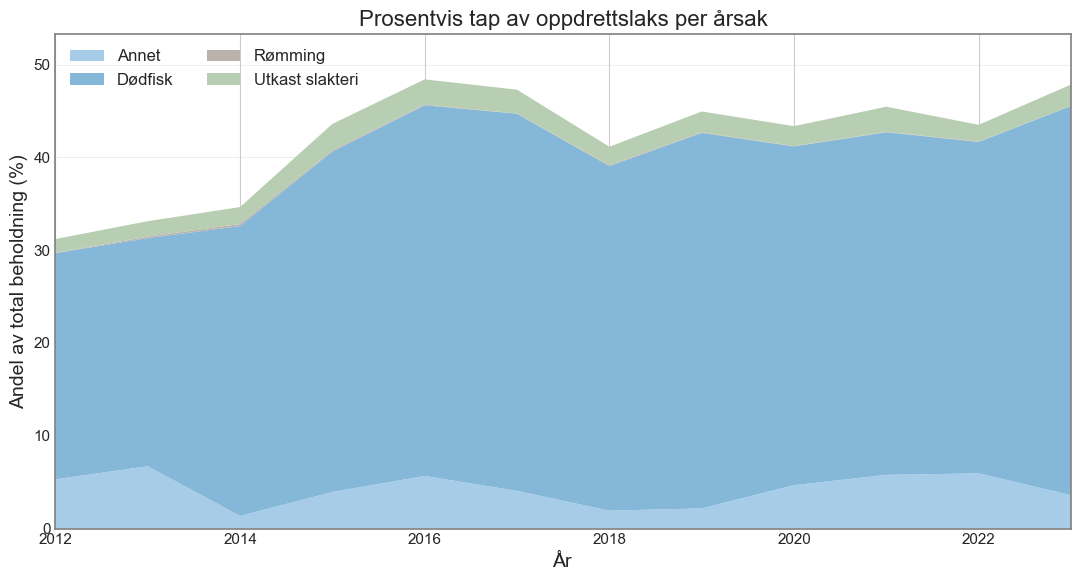

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# --- 1. Les tapsdata ---
tap = pd.read_csv("data/processed/tap_oppdrettslaks.csv")
tap["Antall_fisk"] = tap["Antall (1000)"] * 1000

# --- 2. Les biomasse fra nytt datasett ---
bio = pd.read_csv("data/raw/biostat-total-flk.csv", sep=";")

# Behold kun LAKS
bio = bio[bio["ARTSID"].str.upper() == "LAKS"]

# Rens og konverter
bio["År"] = pd.to_numeric(bio["ÅR"], errors="coerce")
bio["BEHFISK_STK"] = pd.to_numeric(bio["BEHFISK_STK"], errors="coerce")

# Fjern manglende data og grupper
bio = bio.dropna(subset=["År", "BEHFISK_STK"])
bio = bio[bio["År"] >= 2012]

# Beregn gjennomsnitt per fylke per år → summer til total
årsavg = bio.groupby(["År", "FYLKE"])["BEHFISK_STK"].mean().reset_index(name="gjennomsnitt_fylke")
total_fisk = årsavg.groupby("År")["gjennomsnitt_fylke"].sum().reset_index(name="Total_fisk")

# --- 3. Slå sammen og regn prosent tap per årsak ---
tap = pd.merge(tap, total_fisk, left_on="År", right_on="År", how="inner")
tap["Prosent"] = (tap["Antall_fisk"] / tap["Total_fisk"]) * 100

# --- 4. Gjør klar for stacked area chart ---
df_plot = tap.pivot(index="År", columns="Årsak", values="Prosent").fillna(0).sort_index()

# --- 5. Farger og plott ---
farger = {
    "Dødfisk": "#85B7D9",
    "Utkast slakteri": "#B7CEB2",
    "Rømming": "#B9B2AD",
    "Annet": "#A7CCE8"
}

fig, ax = plt.subplots(figsize=(11, 6))
ax.stackplot(df_plot.index,
             [df_plot[c] for c in df_plot.columns],
             labels=df_plot.columns,
             colors=[farger.get(c, "#cccccc") for c in df_plot.columns])

ax.set_title("Prosentvis tap av oppdrettslaks per årsak")
ax.set_xlabel("År")
ax.set_ylabel("Andel av total beholdning (%)")
ax.legend(loc="upper left", ncol=2)
ax.grid(True, which='major', axis='y', alpha=0.3)
ax.set_xlim(df_plot.index.min(), df_plot.index.max())
ax.set_ylim(0, max(df_plot.sum(axis=1)) * 1.1)

plt.tight_layout()
plt.show()
